In [14]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import scipy.stats as ss
from pandas import Series, DataFrame, Panel
%matplotlib inline
%precision 4

u'%.4f'

In [15]:
%load_ext rpy2.ipython
from rpy2.robjects.packages import importr
p1=importr('leaps')
p2=importr('stats')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
# Wrote the source data
df = pd.read_csv('ncaa.data2.txt',delim_whitespace=True)
df.head()
x = df.ix[:,0:19]
y = df.ix[:,19]


In [28]:
def fsr_fast(x,y,gam0,digits,pl):
 m = x.shape[1]
 n = x.shape[0]
 if(m >= n): 
    m1=n-5  
 else: 
    m1=m 
 vm = range(m1)
  # if only partially named columns corrects for no colnames
 pvm = [0] * m1
 out_x = p1.regsubsets(x,y,method="forward")  
 rss = out_x[9]
 nn = out_x[26][0]
 q = [(rss[i]-rss[i+1])*(nn-i-2)/rss[i+1] for i in range(len(rss)-1)]
 rvf = [ ss.f(1,nn-i-2)  for i in range(len(rss)-1)]
 orig =  [1-rvf[i].cdf(q[i]) for i in range(len(rss)-1)]

 # sequential max of pvalues
 for i in range(m1):
   pvm[i] = max(orig[0:i+1])
 alpha = [0]+pvm
 ng = len(alpha)
 # will contain num. of true entering in orig
 S = [0] * ng
 # loop through alpha values for S=size                        
 for ia in range(1,ng):                   
   S[ia] = sum([pvm[i] <= alpha[ia] for i in range(len(pvm))])        # size of models at alpha[ia], S[1]=0
 ghat = [(m-S[i])*alpha[i]/(1+S[i]) for i in range(len(alpha))]              # gammahat_ER 
 # add additional points to make jumps
 alpha2 = np.array(alpha[1:ng])-.0000001
 ghat2 = ((m-np.array(S[0:(ng-1)]))*alpha2)/(1+np.array(S[0:(ng-1)]))
 a= alpha+list(alpha2)
 g=ghat + list(ghat2)
 zp = {'a' : a,
     'g' : g}
 zp = pd.DataFrame(zp)  
 zp=np.array(zp)[np.argsort(zp.a)]
 index_max= np.argmax(zp[:,1])
 alphamax=zp[:,0][index_max]
 ind = [0]*len(ghat)
 ind = [ 1 if ghat[i]<gam0 and alpha[i]<=alphamax else 0 for i in range(len(ghat))]
 Sind = S[np.max(np.where(np.array(ind)>0))]
 alphahat_fast = (1+Sind)*gam0/(m-Sind)
 size1=np.sum(np.array(pvm)<=alphahat_fast)
 x=x[list(x.columns.values[list((np.array(out_x[7])-1)[0:size1])])]
 x=sm.add_constant(x)
 if(size1>1): 
   x_ind=(np.array(out_x[7])-1)[1:size1]
 else:
   x_ind=0
 if (size1==1):
    mod = np.mean(y)
 else:
    mod = sm.OLS(y, x).fit()
 ghat4=(m-size1+1)*np.array(alpha)/(1+np.array(range(m+1)))
 #plt.axis([0,alphamax,0,1.4]) 
 if pl == 1:
  plt.plot(zp[:,0],zp[:,1],'bo',color='red')
  plt.plot([alphahat_fast], [gam0], 'g.', markersize=20.0)
  plt.xlabel('Alpha')
  plt.ylabel('Estimated Gamma')
  plt.axvspan(xmin=-0.1, xmax=alphahat_fast, ymin=0, ymax=0.18)
 return mod,size1-1,x_ind,alphahat_fast

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     1019.
Date:                Thu, 23 Apr 2015   Prob (F-statistic):           6.43e-77
Time:                        21:52:14   Log-Likelihood:                -329.12
No. Observations:                  94   AIC:                             668.2
Df Residuals:                      89   BIC:                             680.9
Df Model:                           5                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2547      0.043      5.956      0.000         0.170     0.340
x3             0.5279      0.060      8.759      0.000         0.408     0.648
x4             0.9585      0.151      6.332      0.000         0.658     1.259
x6             0.2667      0.103      2.578      0.012         0.061     0.472
x5             0.5192      0.067      7.694      0.000         0.385     0.653
==============================================================================
Omnibus:                        4.502   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.399
Skew:                           0.527   Prob(JB):                        0.111
Kurtosis:                       2.892   Cond. No.                         12.0
==============================================================================
"""

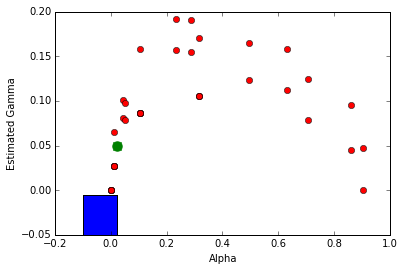

In [29]:
fsr_fast(x,y,0.05,4,1)[0].summary()